In [1]:
import pandas as pd
import numpy as np
# from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import os
from sklearn.preprocessing import MultiLabelBinarizer


In [60]:
movies = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/movies.csv')
ratings= pd.read_csv('/home/manishn/recommend/data/ml-latest-small/ratings.csv')



In [61]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [62]:
movies.shape

(9742, 3)

In [37]:
merged = pd.merge(ratings, movies, on='movieId')
merged= merged[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
merged.to_csv('merged_ratings.csv', index=False)
merged


,userId,movieId,title,genres,rating,timestamp
0,1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,964982703
1,5,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,847434962
2,7,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1106635946
3,15,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",2.5,1510577970
4,17,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1305696483
...,...,...,...,...,...,...
100831,610,160341,Bloodmoon (1997),"[Action, Thriller]",2.5,1479545749
100832,610,160527,Sympathy for the Underdog (1971),"[Action, Crime, Drama]",4.5,1479544998
100833,610,160836,Hazard (2005),"[Action, Drama, Thriller]",3.0,1493844794
100834,610,163937,Blair Witch (2016),"[Horror, Thriller]",3.5,1493848789


In [39]:
data=pd.read_csv('/home/manishn/recommend/merged_ratings.csv')
data.head()
MatrixData=data.drop(['timestamp','genres','title'], axis=1)
MovieUserMatrix = MatrixData.pivot_table(index='movieId',columns='userId',values='rating')
MovieUserMatrix.head()
MovieUserMatrix_Y=MovieUserMatrix.fillna(-1)
MovieUserMatrix_Y
MovieUserMatrix_R=MovieUserMatrix.copy()
MovieUserMatrix_R=MovieUserMatrix_R.where(~MovieUserMatrix_R.notna(), 1)
MovieUserMatrix_R=MovieUserMatrix_R.fillna(0)
MovieUserMatrix_R
Y=MovieUserMatrix_Y.values #converting to numpy array
R=MovieUserMatrix_R.values
Y.shape


(9724, 610)

In [12]:
MatrixData=data.drop(['timestamp','genres','title'], axis=1)
MovieUserMatrix = MatrixData.pivot_table(index='movieId',columns='userId',values='rating')
MovieUserMatrix.head()


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import numpy as np

def train_test_split(Y, R, test_size=0.2, random_state=None):
    """
    Train and test split for user-item interaction matrix and binary indicator matrix.
    
    Parameters
    ----------
    Yratings: numpy array-like
        User-item interaction matrix of shape (m, n) where m = users, n = movies
    Rratings: numpy array-like
        Binary-valued indicator matrix of shape (m, n) indicating whether a rating is present (1) or not (0)
    test_size: float
        Proportion of the dataset to include in the test split (default is 0.2)
    random_state: int or None
        Random seed for reproducibility (default is None)
    
    Returns
    -------
    Ytrain: numpy array-like
        Train user-item interaction matrix
    Ytest: numpy array-like
        Test user-item interaction matrix
    Rtrain: numpy array-like
        Train binary indicator matrix for user-item interactions
    Rtest: numpy array-like
        Test binary indicator matrix for user-item interactions
    """
    
    # Set random seed for reproducibility if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the indices of the rated items
    rated_indices = np.argwhere(R == 1)  # Get indices where Rratings is 1

    # Shuffle the indices randomly
    np.random.shuffle(rated_indices)

    # Calculate the number of test samples
    total_test_size = int(len(rated_indices) * test_size)

    # Split the indices into train and test sets
    test_indices = rated_indices[:total_test_size]
    train_indices = rated_indices[total_test_size:]

    # Initialize the train and test matrices
    Ytrain = np.zeros_like(Y)
    Ytest = np.zeros_like(Y)
    Rtrain = np.zeros_like(R)
    Rtest = np.zeros_like(R)

    # Populate the train and test matrices
    for index in train_indices:
        Ytrain[index[0], index[1]] = Y[index[0], index[1]]
        Rtrain[index[0], index[1]] = 1  # Mark this as rated in Rtrain

    for index in test_indices:
        Ytest[index[0], index[1]] = Y[index[0], index[1]]
        Rtest[index[0], index[1]] = 1  # Mark this as rated in Rtest

    return Ytrain, Ytest, Rtrain, Rtest


In [14]:
#Implementation of Collaborative filtering Cost function and gradient, regularized and non regularized
def  cofiCostFunc(all_parameters_vector, Y, R, num_users, num_movies, num_features, Lambda):
    """
            calculates Collaborative filtering Cost function and gradient both regularized and non regularized
            
            Parameters
            ----------
            total_parameters: numpy array-like
                    initial values for users parameter vectors and movies feature vectors
            
            Y: numpy array-like
                    user-item interaction matrix
            R: numpy arra-like
                    Its a binary-valued indicator matrix for user-item interaction matrix
            num_users: int-like
                    total number of users
            num_movies: int-like
                    total number of movies
            Lambda: Float-like
                    Regularization parameter
                    
            Returns
            -------
            J:Float-like
                    Cost
            grad:Float-like
                    Gradient
            reg_J:Float-like
                    Regularized Cost
            reg_grad:Float-like
                    Regularized gradient
    """
    # Unfold the params
    U = all_parameters_vector[:num_movies*num_features].reshape(num_movies,num_features)
    V = all_parameters_vector[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  np.dot(U,V.T)
    err = (predictions - Y)
    loss = 1/2 * np.sum((err**2) * R) # multiplying by R will consider only those values for which value of (i,j)=r(i,j)=1
    
    #compute regularized cost function
    reg_U =  Lambda/2 * np.sum(U**2)
    reg_V = Lambda/2 *np.sum(U**2)
    reg_loss = loss + reg_U + reg_V

    
    # Compute gradient
    U_grad = np.dot(err*R,V)
    V_grad = np.dot((err*R).T,U)
    gradients = np.append(U_grad.flatten(),V_grad.flatten()) #flattening calculated gradients of 4*3 dim into 12 real number one dim of vector for optimization algo since optimization algorithms deals with vectos not matrix 
    
    # Compute regularized gradient
    reg_X_grad = U_grad + Lambda*U
    reg_Theta_grad = V_grad + Lambda*V
    reg_gradients = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    #, reg_J, reg_grad
    
    return loss, gradients, reg_loss, reg_gradients


import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

def gradientDescent(initial_parameters, Y, R, num_users, num_movies, num_features, alpha, num_iters, Lambda):
    """
    Optimize X and Theta
    
    Parameters
    ----------
    initial_parameters: numpy array-like
        Initial values for users parameter vectors and movies feature vectors
    
    Y: numpy array-like
        User-item interaction matrix
    R: numpy array-like
        Binary-valued indicator matrix for user-item interaction matrix
    num_users: int-like
        Total number of users
    num_movies: int-like
        Total number of movies
    alpha: Float-like
        Learning rate
    num_iters: integer-like
        Number of iterations of optimization algorithm
    Lambda: Float-like
        Regularization parameter
        
    Returns
    -------
    paramsFinal: numpy-array-like
        Learned user parameters and feature vectors for movies
    J_history: numpy-array-like
        History of decrease in cost as gradient descent moves towards global minima
    """
    # Unfold the parameters
    U = initial_parameters[:num_movies * num_features].reshape(num_movies, num_features)
    V = initial_parameters[num_movies * num_features:].reshape(num_users, num_features)
    
    loss_history = []
    
    # Wrap the loop with tqdm for progress tracking
    for _ in tqdm(range(num_iters), desc="Training Progress"):
        params = np.append(U.flatten(), V.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # Unfold grad
        U_grad = grad[:num_movies * num_features].reshape(num_movies, num_features)
        V_grad = grad[num_movies * num_features:].reshape(num_users, num_features)
        
        U -= alpha * U_grad
        V -= alpha * V_grad
        loss_history.append(cost)
    
    paramsFinal = np.append(U.flatten(), V.flatten())
    return paramsFinal, loss_history


In [15]:
#Train-Test split
Ytrain, Ytest, Rtrain, Rtest = train_test_split(Y,R)
num_users = Ytrain.shape[1]
num_movies = Ytrain.shape[0]
num_features = 200


# Set initial Parameters (Theta,X)
U = np.random.randn(num_movies, num_features)
V = np.random.randn(num_users, num_features)


initial_parameters = np.append(U.flatten(),V.flatten())
Lambda = 10

# learns Features for movies and parameters for all users using Collaborative filtering
final_parameter, cost_history = gradientDescent(initial_parameters,Ytrain,Rtrain,num_users,num_movies,num_features,0.001,1000,Lambda)
U = final_parameter[:num_movies*num_features].reshape(num_movies,num_features)
V = final_parameter[num_movies*num_features:].reshape(num_users,num_features)




Training Progress: 100%|██████████| 1000/1000 [17:26<00:00,  1.05s/it]


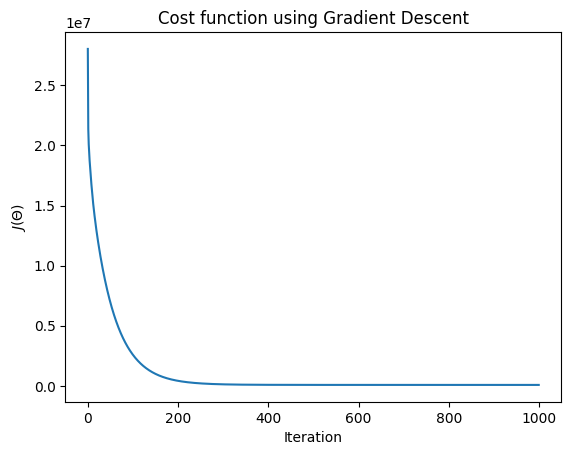

In [84]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
U = final_parameter[:num_movies*num_features].reshape(num_movies,num_features)
V = final_parameter[num_movies*num_features:].reshape(num_users,num_features)


In [18]:
predicted=np.dot(U,V.T)
predicted.shape
import numpy as np

def computeTestError(Y_test, R_test, Y_pred):

    error = (Y_pred - Y_test) * R_test  # Only consider entries where R_test == 1
    
    
    squared_error = np.square(error)
    
    mse = np.sum(squared_error) / np.count_nonzero(R_test)
    
    return np.sqrt(mse)

# Compute RMSE
rmse = computeTestError(Ytest, Rtest,predicted)
print(f"Test RMSE: {rmse}")


Test RMSE: 1.2612123406390425


In [21]:
movies_features=U
movies_features.shape

(9724, 200)

In [134]:
import pandas as pd
import numpy as np
merged = pd.merge(ratings, movies, on='movieId')
merged = merged[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
merged.to_csv('merged_ratings.csv', index=False)

# Load merged data
data = pd.read_csv('merged_ratings.csv')

# Prepare Movie-User Matrix
MatrixData = data.drop(['timestamp', 'genres', 'title'], axis=1)
MovieUserMatrix = MatrixData.pivot_table(index='movieId', columns='userId', values='rating')

# Prepare Y and R matrices
MovieUserMatrix_Y = MovieUserMatrix.fillna(-1)
MovieUserMatrix_R = MovieUserMatrix.notna().astype(int)  # Binary indicator matrix
Y = MovieUserMatrix_Y.values  # User-item interaction matrix
R = MovieUserMatrix_R.values   # Binary user-item interaction matrix

# Assuming U and V are already defined as user features and movie features
user_features = V  # Replace with your actual user features matrix
movie_features = U  # Replace with your actual movie features matrix

# Make predictions
def predict_rating(user_id, movie_id):
    user_idx = MovieUserMatrix.columns.get_loc(user_id)
    movie_idx = MovieUserMatrix.index.get_loc(movie_id)
    prediction = np.dot(user_features[user_idx], movie_features[movie_idx])
    return prediction

# Display top N recommendations with titles for unrated movies
def top_n_recommendations(user_id, n=10):
    predictions = []
    # Get the index for the user
    user_idx = MovieUserMatrix.columns.get_loc(user_id)

    for movie_id in MovieUserMatrix.index:
        movie_idx = MovieUserMatrix.index.get_loc(movie_id)
        
        # Only consider movies that have not been rated yet by the user
        if R[movie_idx, user_idx] == 0:  # Check if the movie has not been rated
            prediction = predict_rating(user_id, movie_id)
            predictions.append((movie_id, prediction))
    
    # Sort predictions by rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]
    
    # Prepare a DataFrame for the top N recommendations
    recommended_movies = pd.DataFrame(top_n, columns=['movieId', 'Predicted Rating'])
    
    # Merge with the movies DataFrame to get movie titles
    recommended_movies = recommended_movies.merge(movies[['movieId', 'title']], on='movieId')
    
    # Return only the relevant columns
    return recommended_movies[['movieId', 'title', 'Predicted Rating']]

# Example usage
user_id = 10  # Replace with a valid user ID
n = 10  # Number of recommendations
recommended_movies = top_n_recommendations(user_id, n)

# Print recommendations
print(recommended_movies)


   movieId                                           title  Predicted Rating
0     3753                             Patriot, The (2000)          3.796340
1    69757                     (500) Days of Summer (2009)          3.675235
2     3916                      Remember the Titans (2000)          3.622361
3     2424                          You've Got Mail (1998)          3.585639
4    72641                         Blind Side, The  (2009)          3.570087
5    33166                                    Crash (2004)          3.551370
6     1721                                  Titanic (1997)          3.536661
7     5816  Harry Potter and the Chamber of Secrets (2002)          3.525404
8     2572               10 Things I Hate About You (1999)          3.511571
9      953                    It's a Wonderful Life (1946)          3.503798


In [138]:
movies=pd.read_csv('data/ml-latest-small/movies.csv')

In [139]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

mlb = MultiLabelBinarizer()
genre_indicators = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes_, index=movies.index)


In [140]:

# Step 2: Add genre indicators to movies dataset
movies_with_genres = pd.concat([movies.drop('genres', axis=1), genre_indicators], axis=1)
movies_with_genres
movies_ratings_genres = pd.merge(ratings, movies_with_genres, on='movieId')
movies_ratings_genres

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,160836,3.0,1493844794,Hazard (2005),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610,163937,3.5,1493848789,Blair Witch (2016),0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [105]:
data = pd.read_csv('/home/manishn/recommend/merged_ratings.csv')

# Create the MovieUserMatrix
MatrixData = data.drop(['timestamp', 'genres', 'title'], axis=1)
MovieUserMatrix = MatrixData.pivot_table(index='movieId', columns='userId', values='rating')

# Get the rated movie IDs
rated_movie_ids = MovieUserMatrix.index.tolist()

movies_with_genres_filtered = movies_with_genres[movies_with_genres['movieId'].isin(rated_movie_ids)]

# Step 2: Extract genre indicators
genre_columns = movies_with_genres_filtered.columns[2:]  # All columns except title
genre_indicators = movies_with_genres_filtered[genre_columns].to_numpy()  # Shape: (num_filtered_movies, num_genres)

# Step 3: Combine latent features and genre indicators
combined_movie_features = np.hstack((U, genre_indicators))  # Shape: (num_filtered_movies, latent_dim + num_genres)

combined_movie_features.shape

(9724, 220)

In [106]:
combined_movie_features=np.array(combined_movie_features)

In [119]:

def CBgradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    U : array_like
        Matrix of features for all movies.
    
    y : array_like
        Binary vector of ratings.
    
    theta : array_like
        Initial values for user parameters.
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned parameters. 
    """
    X = np.array(X)
    y = np.array(y)
    theta = np.array(theta)

    m = float(y.shape[0])
    theta = theta.copy()  # Ensure the original theta is not modified
    for i in range(num_iters):
        error = np.dot(X, theta) - y  # Prediction errors
        theta -= (alpha/m) * np.dot(X.T, error)  # Update theta
    return theta


def prediction_with_features(X, my_ratings, moviesdataset):
    """
    Performs prediction for movie recommendations based on user ratings and movie features.
    
    Parameters
    ----------
    X : array_like
        A matrix of features for all movies (shape: m x d), where m is the number of movies and d is the number of features.
    
    my_ratings : numpy-array-like
        A binary vector of movie ratings provided by the user (shape: m), where 1 indicates the movie is rated and 0 indicates it is not.
                    
    moviesdataset : pandas DataFrame
        A DataFrame containing movie information (movieId, title, etc.) for all m movies.
    
    Returns
    -------
    sorted_data : DataFrame
        The top-N recommended movies sorted by predicted ratings.
    """
    
    # Extract the ratings provided by the user, ignoring the un-rated movies
    out_arr = my_ratings[np.nonzero(my_ratings)]  # Shape: (k,), where k is the number of rated movies
    out_arr = out_arr.reshape(-1, 1)               # Reshape to (k, 1) for compatibility with other operations

    # Get the indices of the rated movies
    idx = np.where(my_ratings)[0]                  # Shape: (k,)
    
    # Collect the features of the rated movies
    X_1 = [X[x] for x in idx]                      # List of shape (k, d), where d is the number of features
    X_1 = np.array(X_1)                            # Convert to NumPy array, shape: (k, d)
    
    # Reshape the ratings for compatibility
    y = out_arr                                     # Shape: (k, 1)
    y = np.reshape(y, -1)                           # Reshape to (k,) for gradient descent

    # Perform gradient descent to learn the parameters (theta) based on the rated movies
    theta = CBgradientDescent(X_1, y, np.zeros((220)), 0.001, 4000)
    # Here, theta will have shape: (n,) after optimization
    # print(theta)
    # Predict ratings for all movies using learned parameters
    p = X @ theta.T                                 # Shape: (m,) where m is the number of movies
    p = np.reshape(p, -1)                           # Ensure p is a 1D array

    # Prepare the predicted data for sorting
    predictedData = moviesdataset.copy()            # Create a copy of the original DataFrame
    predictedData['Prediction'] = p                 # Add predicted ratings to the DataFrame

    # Sort the DataFrame based on predicted ratings in descending order
    sorted_data = predictedData.sort_values(by=['Prediction'], ascending=False)
    
    # Return the top 10 recommended movies
    return sorted_data[:10]                         # Shape: (10, p+1), where p is the number of columns in moviesdataset


In [120]:


#cleaning and transforming moviesDataset to use it on web-application 
moviesdataset=merged.drop(['userId','rating','timestamp','genres'],axis=1)
moviesdataset=moviesdataset.drop_duplicates()
moviesdataset=moviesdataset.sort_values("movieId")
moviesdataset=moviesdataset.reset_index(drop=True)
moviesdataset["title"] = moviesdataset["title"].str.lower() 
moviesdataset["title"] = moviesdataset["title"].str.replace(r"\(.*\)","")
moviesdataset.head()

my_ratings = np.zeros((9724,1))


my_ratings[277]=5
print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for Movie")
        print((moviesdataset.iloc[i]).title)
# top-N-movies
# my_ratings
prediction_with_features(combined_movie_features,my_ratings,moviesdataset)

New user ratings:

Rated 5 for Movie
shawshank redemption, the (1994)


,movieId,title,Prediction
277,318,"shawshank redemption, the (1994)",5.000000
257,296,pulp fiction (1994),3.915955
2224,2959,fight club (1999),3.547844
6693,58559,"dark knight, the (2008)",3.450391
659,858,"godfather, the (1972)",3.448885
314,356,forrest gump (1994),3.389692
97,110,braveheart (1995),3.379961
461,527,schindler's list (1993),3.361783
2370,3147,"green mile, the (1999)",3.325082
46,50,"usual suspects, the (1995)",3.291924


In [121]:

def CBgradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    U : array_like
        Matrix of features for all movies.
    
    y : array_like
        vector of ratings.
    
    theta : array_like
        Initial values for user parameters.
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned parameters. 
    """
    X = np.array(X)
    y = np.array(y)
    theta = np.array(theta)

    m = float(y.shape[0])
    theta = theta.copy()  # Ensure the original theta is not modified
    for i in range(num_iters):
        error = np.dot(X, theta) - y  # Prediction errors
        theta -= (alpha/m) * np.dot(X.T, error)  # Update theta
    return theta


def prediction(X, my_ratings, moviesdataset):
    """
    Performs prediction for movie recommendations based on user ratings and movie features.
    
    Parameters
    ----------
    X : array_like
        A matrix of features for all movies (shape: m x d), where m is the number of movies and d is the number of features.
    
    my_ratings : numpy-array-like
        A binary vector of movie ratings provided by the user (shape: m), where 1 indicates the movie is rated and 0 indicates it is not.
                    
    moviesdataset : pandas DataFrame
        A DataFrame containing movie information (movieId, title, etc.) for all m movies.
    
    Returns
    -------
    sorted_data : DataFrame
        The top-N recommended movies sorted by predicted ratings.
    """
    
    # Extract the ratings provided by the user, ignoring the un-rated movies
    out_arr = my_ratings[np.nonzero(my_ratings)]  # Shape: (k,), where k is the number of rated movies
    out_arr = out_arr.reshape(-1, 1)               # Reshape to (k, 1) for compatibility with other operations

    # Get the indices of the rated movies
    idx = np.where(my_ratings)[0]                  # Shape: (k,)
    
    # Collect the features of the rated movies
    X_1 = [X[x] for x in idx]                      # List of shape (k, d), where d is the number of features
    X_1 = np.array(X_1)                            # Convert to NumPy array, shape: (k, d)
    
    # Reshape the ratings for compatibility
    y = out_arr                                     # Shape: (k, 1)
    y = np.reshape(y, -1)                           # Reshape to (k,) for gradient descent

    # Perform gradient descent to learn the parameters (theta) based on the rated movies
    theta = CBgradientDescent(X_1, y, np.zeros((200)), 0.001, 4000)
    # Here, theta will have shape: (n,) after optimization
    # print(theta)
    # Predict ratings for all movies using learned parameters
    p = X @ theta.T                                 # Shape: (m,) where m is the number of movies
    p = np.reshape(p, -1)                           # Ensure p is a 1D array

    # Prepare the predicted data for sorting
    predictedData = moviesdataset.copy()            # Create a copy of the original DataFrame
    predictedData['Prediction'] = p                 # Add predicted ratings to the DataFrame

    # Sort the DataFrame based on predicted ratings in descending order
    sorted_data = predictedData.sort_values(by=['Prediction'], ascending=False)
    
    # Return the top 10 recommended movies
    return sorted_data[:10]                         # Shape: (10, p+1), where p is the number of columns in moviesdataset


#cleaning and transforming moviesDataset to use it on web-application 
moviesdataset=merged.drop(['userId','rating','timestamp','genres'],axis=1)
moviesdataset=moviesdataset.drop_duplicates()
moviesdataset=moviesdataset.sort_values("movieId")
moviesdataset=moviesdataset.reset_index(drop=True)
moviesdataset["title"] = moviesdataset["title"].str.lower() 
moviesdataset["title"] = moviesdataset["title"].str.replace(r"\(.*\)","")
moviesdataset.head()

my_ratings = np.zeros((9724,1))


my_ratings[277]=5
print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for Movie")
        print((moviesdataset.iloc[i]).title)
# top-N-movies
# my_ratings
prediction(U,my_ratings,moviesdataset)


New user ratings:

Rated 5 for Movie
shawshank redemption, the (1994)


,movieId,title,Prediction
277,318,"shawshank redemption, the (1994)",5.000000
314,356,forrest gump (1994),3.672098
97,110,braveheart (1995),3.659279
461,527,schindler's list (1993),3.635330
257,296,pulp fiction (1994),3.571857
46,50,"usual suspects, the (1995)",3.543296
510,593,"silence of the lambs, the (1991)",3.488036
398,457,"fugitive, the (1993)",3.226219
43,47,seven (a.k.a. se7en) (1995),3.217292
31,32,twelve monkeys (a.k.a. 12 monkeys) (1995),3.158500
